In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import random
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import r2_score,mean_absolute_error, mean_squared_error
from transformers import RobertaTokenizer, RobertaModel
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from torch.utils.data import DataLoader, Subset
from scipy.stats import pearsonr
from tqdm import tqdm
from sklearn.exceptions import FitFailedWarning
import warnings
from sklearn.model_selection import ParameterSampler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
from scipy.stats import norm
import matplotlib
from sklearn.base import clone


In [2]:
import pandas as pd
from rdkit import Chem

# 读取数据
data = pd.read_csv("../imputed_selected_features_Flam.csv")
data = data.dropna()  # 删除缺失值
smiles_data = data['SMILES'].tolist()
labels=data['Flammability'].tolist()


In [3]:
import torch

# 检查是否有可用的 GPU
if torch.cuda.is_available():
    print("CUDA 可用，GPU 可用。")
    print(f"CUDA 版本: {torch.version.cuda}")
    print(f"GPU 数量: {torch.cuda.device_count()}")
    print(f"当前设备名称: {torch.cuda.get_device_name(0)}")
    print(f"当前设备总内存: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
else:
    print("CUDA 不可用，仅支持 CPU。")


CUDA 可用，GPU 可用。
CUDA 版本: 12.1
GPU 数量: 1
当前设备名称: NVIDIA vGPU-32GB
当前设备总内存: 31.50 GB


In [4]:
# 数据增强函数：简单的 SMILES 序列翻转
def augment_smiles(smiles):
    """简单的数据增强方法，例如旋转 SMILES 字符串"""
    if random.random() > 0.5:
        return smiles[::-1]  # 翻转字符串
    return smiles



class SMILES_Dataset(Dataset):
    def __init__(self, smiles, class_labels):
        self.smiles = smiles  # SMILES字符串列表
        self.class_labels = class_labels  # 分类任务标签

    def __len__(self):
        return len(self.smiles)

    def __getitem__(self, idx):
        # smiles = augment_smiles(self.smiles[idx])  # 如果需要数据增强，可以启用这行
        smiles = self.smiles[idx]  # 获取单个SMILES
        class_label = self.class_labels[idx]  # 获取对应的分类标签
        tokens = tokenizer(smiles, padding='max_length', truncation=True, max_length=128, return_tensors="pt")
        return tokens, torch.tensor(class_label, dtype=torch.long)



class ChemBERTa_Classifier(nn.Module):
    def __init__(self, num_classes):
        super(ChemBERTa_Classifier, self).__init__()
        # 加载预训练的ChemBERTa模型
        self.chemberta = chemberta_model  # 假设chemberta_model已定义
        hidden_size = self.chemberta.config.hidden_size  # 一般为768

        # 分类任务的全连接层
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.3),
            nn.Linear(512, 2)
        )

    def forward(self, tokens):
        output = self.chemberta(**tokens)
        cls_embedding = output.last_hidden_state[:, 0, :]  # [CLS] token 嵌入
        class_output = self.classifier(cls_embedding)  # 分类任务输出
        return class_output

In [5]:
# 加载 ChemBERTa 模型和 tokenizer
model_name = "../CE/ChemBERTa"
tokenizer = RobertaTokenizer.from_pretrained(model_name)
chemberta_model = RobertaModel.from_pretrained(model_name)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ChemBERTa_Classifier(num_classes=2).to(device)  
# 加载最佳模型
model.load_state_dict(torch.load('../CE/best_chemberta_model.pth'))

<All keys matched successfully>

In [6]:
# 提取 SMILES 的嵌入表示
def extract_embeddings(smiles_list, model, tokenizer, device):
    embeddings = []
    model.eval()  # 设置模型为评估模式
    with torch.no_grad():
        for smiles in smiles_list:
            # Tokenize the SMILES string
            tokens = tokenizer(smiles, return_tensors="pt", padding=True, truncation=True, max_length=128).to(device)
            
            # 通过 ChemBERTa 模型获得输出
            outputs = model.chemberta(**tokens)  # 提取 ChemBERTa 模型的输出
            
            # 提取 [CLS] token 的嵌入作为 SMILES 的整体嵌入
            cls_embedding = outputs.last_hidden_state[:, 0, :].cpu().numpy()  # 获取多维的 [CLS] 嵌入
            embeddings.append(cls_embedding)
    
    return np.vstack(embeddings)  # 将所有嵌入拼接成一个矩阵

In [7]:
# 提取嵌入
smiles_embeddings = extract_embeddings(smiles_data, model, tokenizer, device)

In [8]:
# 使用 PCA 对嵌入进行降维，同时获取主成分的解释方差百分比
def apply_pca(embeddings, n_components=2):
    pca = PCA(n_components=n_components)
    pca_result = pca.fit_transform(embeddings)
    explained_variance = pca.explained_variance_ratio_  # 获取每个主成分的解释方差
    return pca_result, explained_variance

# 可视化函数，同时显示解释方差百分比
def plot_pca_with_variance(pca_result, labels, explained_variance):
    plt.figure(figsize=(8, 6), dpi=300)
    
    # 为 labels 只有 0 和 1 两个值指定两个颜色
    scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=labels, cmap='coolwarm', alpha=0.9, s=4)

    plt.xlabel(f'PCA 1  {explained_variance[0]*100:.2f}% ', fontsize=20)
    plt.ylabel(f'PCA 2  {explained_variance[1]*100:.2f}% ', fontsize=20)

    # 添加图例，手动指定标签
    plt.legend(handles=scatter.legend_elements()[0], labels=['Label 0', 'Label 1'], loc='best', fontsize=17,frameon=False)
    
    # 获取当前坐标轴对象
    ax = plt.gca()

    # 设置所有边框的可见性，并确保框线颜色正常显示
    ax.spines['top'].set_visible(True)    # 显示顶部框线
    ax.spines['right'].set_visible(True)  # 显示右侧框线
    ax.spines['top'].set_color('black')   # 设置顶部框线颜色为黑色
    ax.spines['right'].set_color('black') # 设置右侧框线颜色为黑色
    ax.spines['top'].set_linewidth(1.5)   # 设置顶部框线的宽度
    ax.spines['right'].set_linewidth(1.5) # 设置右侧框线的宽度

    # 让其余边框可见（通常默认已可见）
    ax.spines['top'].set_visible(False)  # 隐藏左侧框线
    ax.spines['right'].set_visible(False)  # 隐藏底部框线
    
    ax.tick_params(axis='both', labelsize=15)  # 设置x轴和y轴刻度标签的字体大小为12

    plt.show()


# 使用 PCA 降维，并获取解释方差
pca_result, explained_variance = apply_pca(smiles_embeddings, n_components=2)

# 绘制 PCA 图，并显示每个主成分的解释方差百分比
#plot_pca_with_variance(pca_result, labels, explained_variance)

In [11]:
# 可视化函数，同时显示解释方差百分比，并加粗字体
def plot_pca_with_variance(pca_result, labels, explained_variance):
    plt.figure(figsize=(8, 6), dpi=300)
    
    # 为 labels 只有 0 和 1 两个值指定两个颜色
    scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=labels, cmap='coolwarm', alpha=0.9, s=4)

    # 加粗字体并增大字号
    plt.xlabel(f'PCA 1  {explained_variance[0]*100:.2f}% ', fontsize=20, fontweight='bold')
    plt.ylabel(f'PCA 2  {explained_variance[1]*100:.2f}% ', fontsize=20, fontweight='bold')

    # 添加图例，手动指定标签
    legend = plt.legend(
        handles=scatter.legend_elements()[0], 
        labels=['Label 0', 'Label 1'], 
        loc='best', 
        fontsize=17,
        frameon=False
    )
    for text in legend.get_texts():
        text.set_fontweight('bold')  # 加粗图例文字

    # 获取当前坐标轴对象
    ax = plt.gca()

    # 设置所有边框的可见性，并确保框线颜色正常显示
    # 让其余边框可见（通常默认已可见）
    ax.spines['top'].set_visible(False)  # 隐藏左侧框线
    ax.spines['right'].set_visible(False)  # 隐藏底部框线
    ax.spines['top'].set_color('black')   
    ax.spines['right'].set_color('black') 
    ax.spines['top'].set_linewidth(1.5)   
    ax.spines['right'].set_linewidth(1.5) 

    # 让其余边框可见（通常默认已可见）
    ax.spines['bottom'].set_visible(True)  
    ax.spines['left'].set_visible(True)  
    ax.spines['bottom'].set_color('black')  
    ax.spines['left'].set_color('black')  
    ax.spines['bottom'].set_linewidth(1.5)  
    ax.spines['left'].set_linewidth(1.5)  

    # 加粗 x 轴和 y 轴的刻度
    ax.tick_params(axis='both', labelsize=15, width=2)
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontweight('bold')  # 加粗刻度标签

    plt.show()

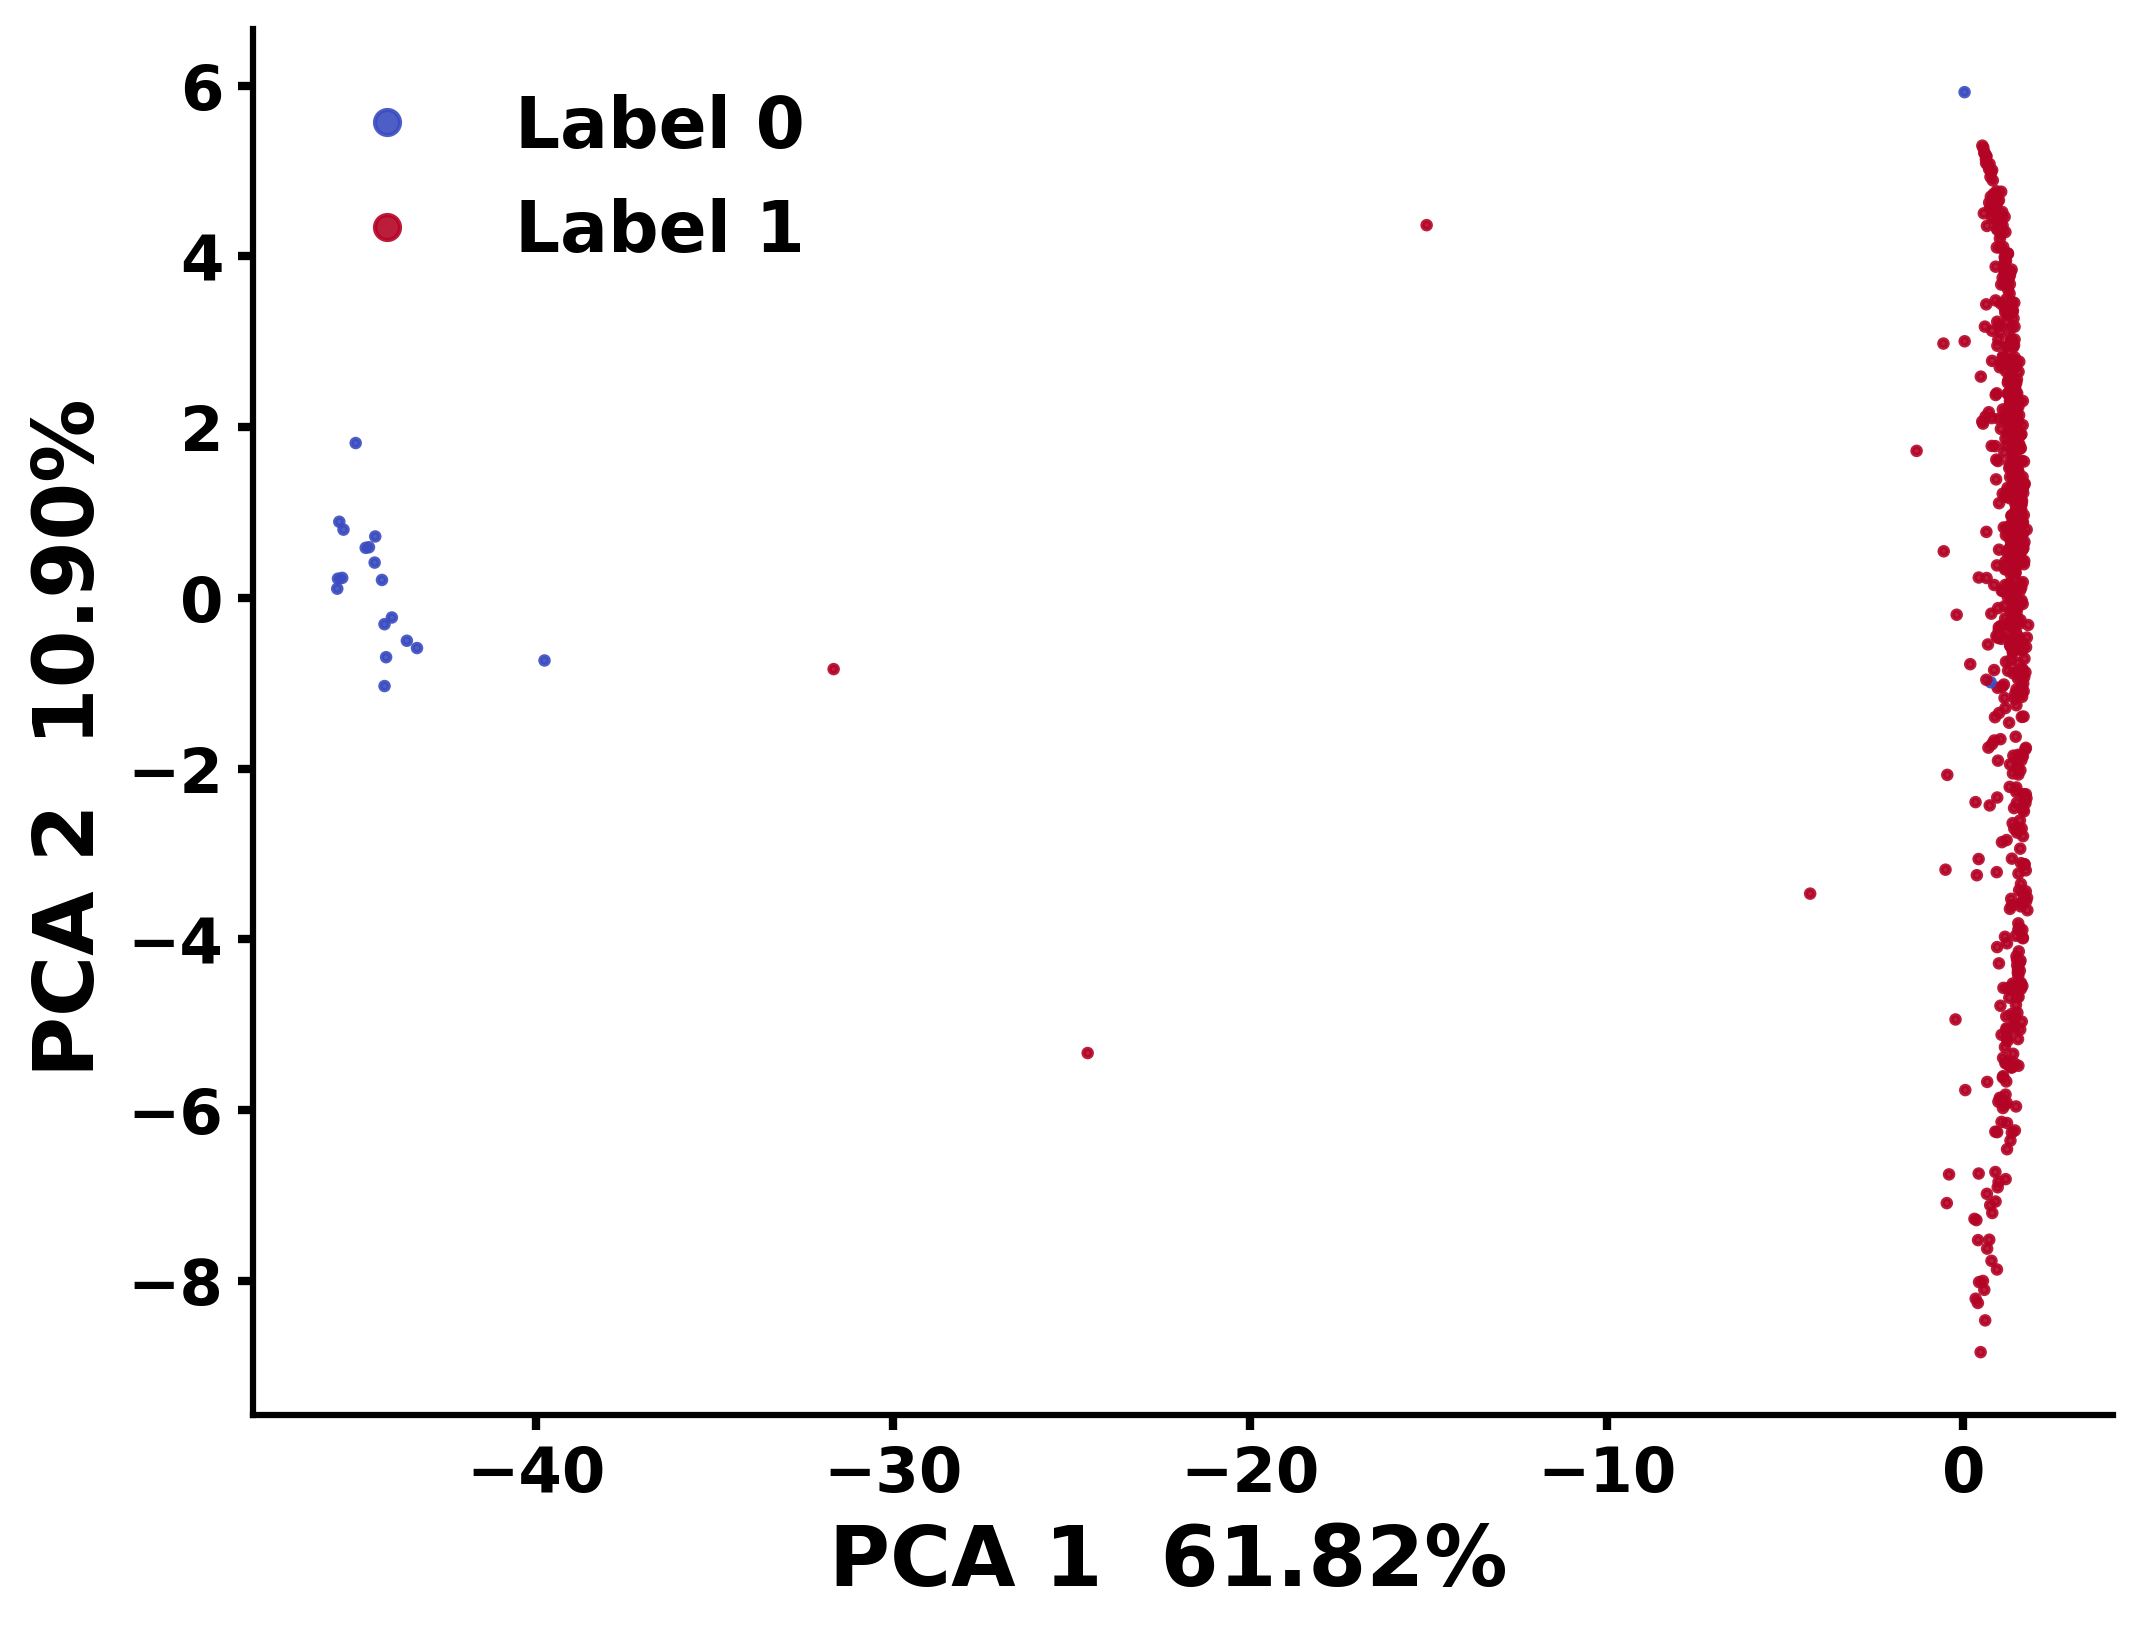

In [12]:
plot_pca_with_variance(pca_result, labels, explained_variance)

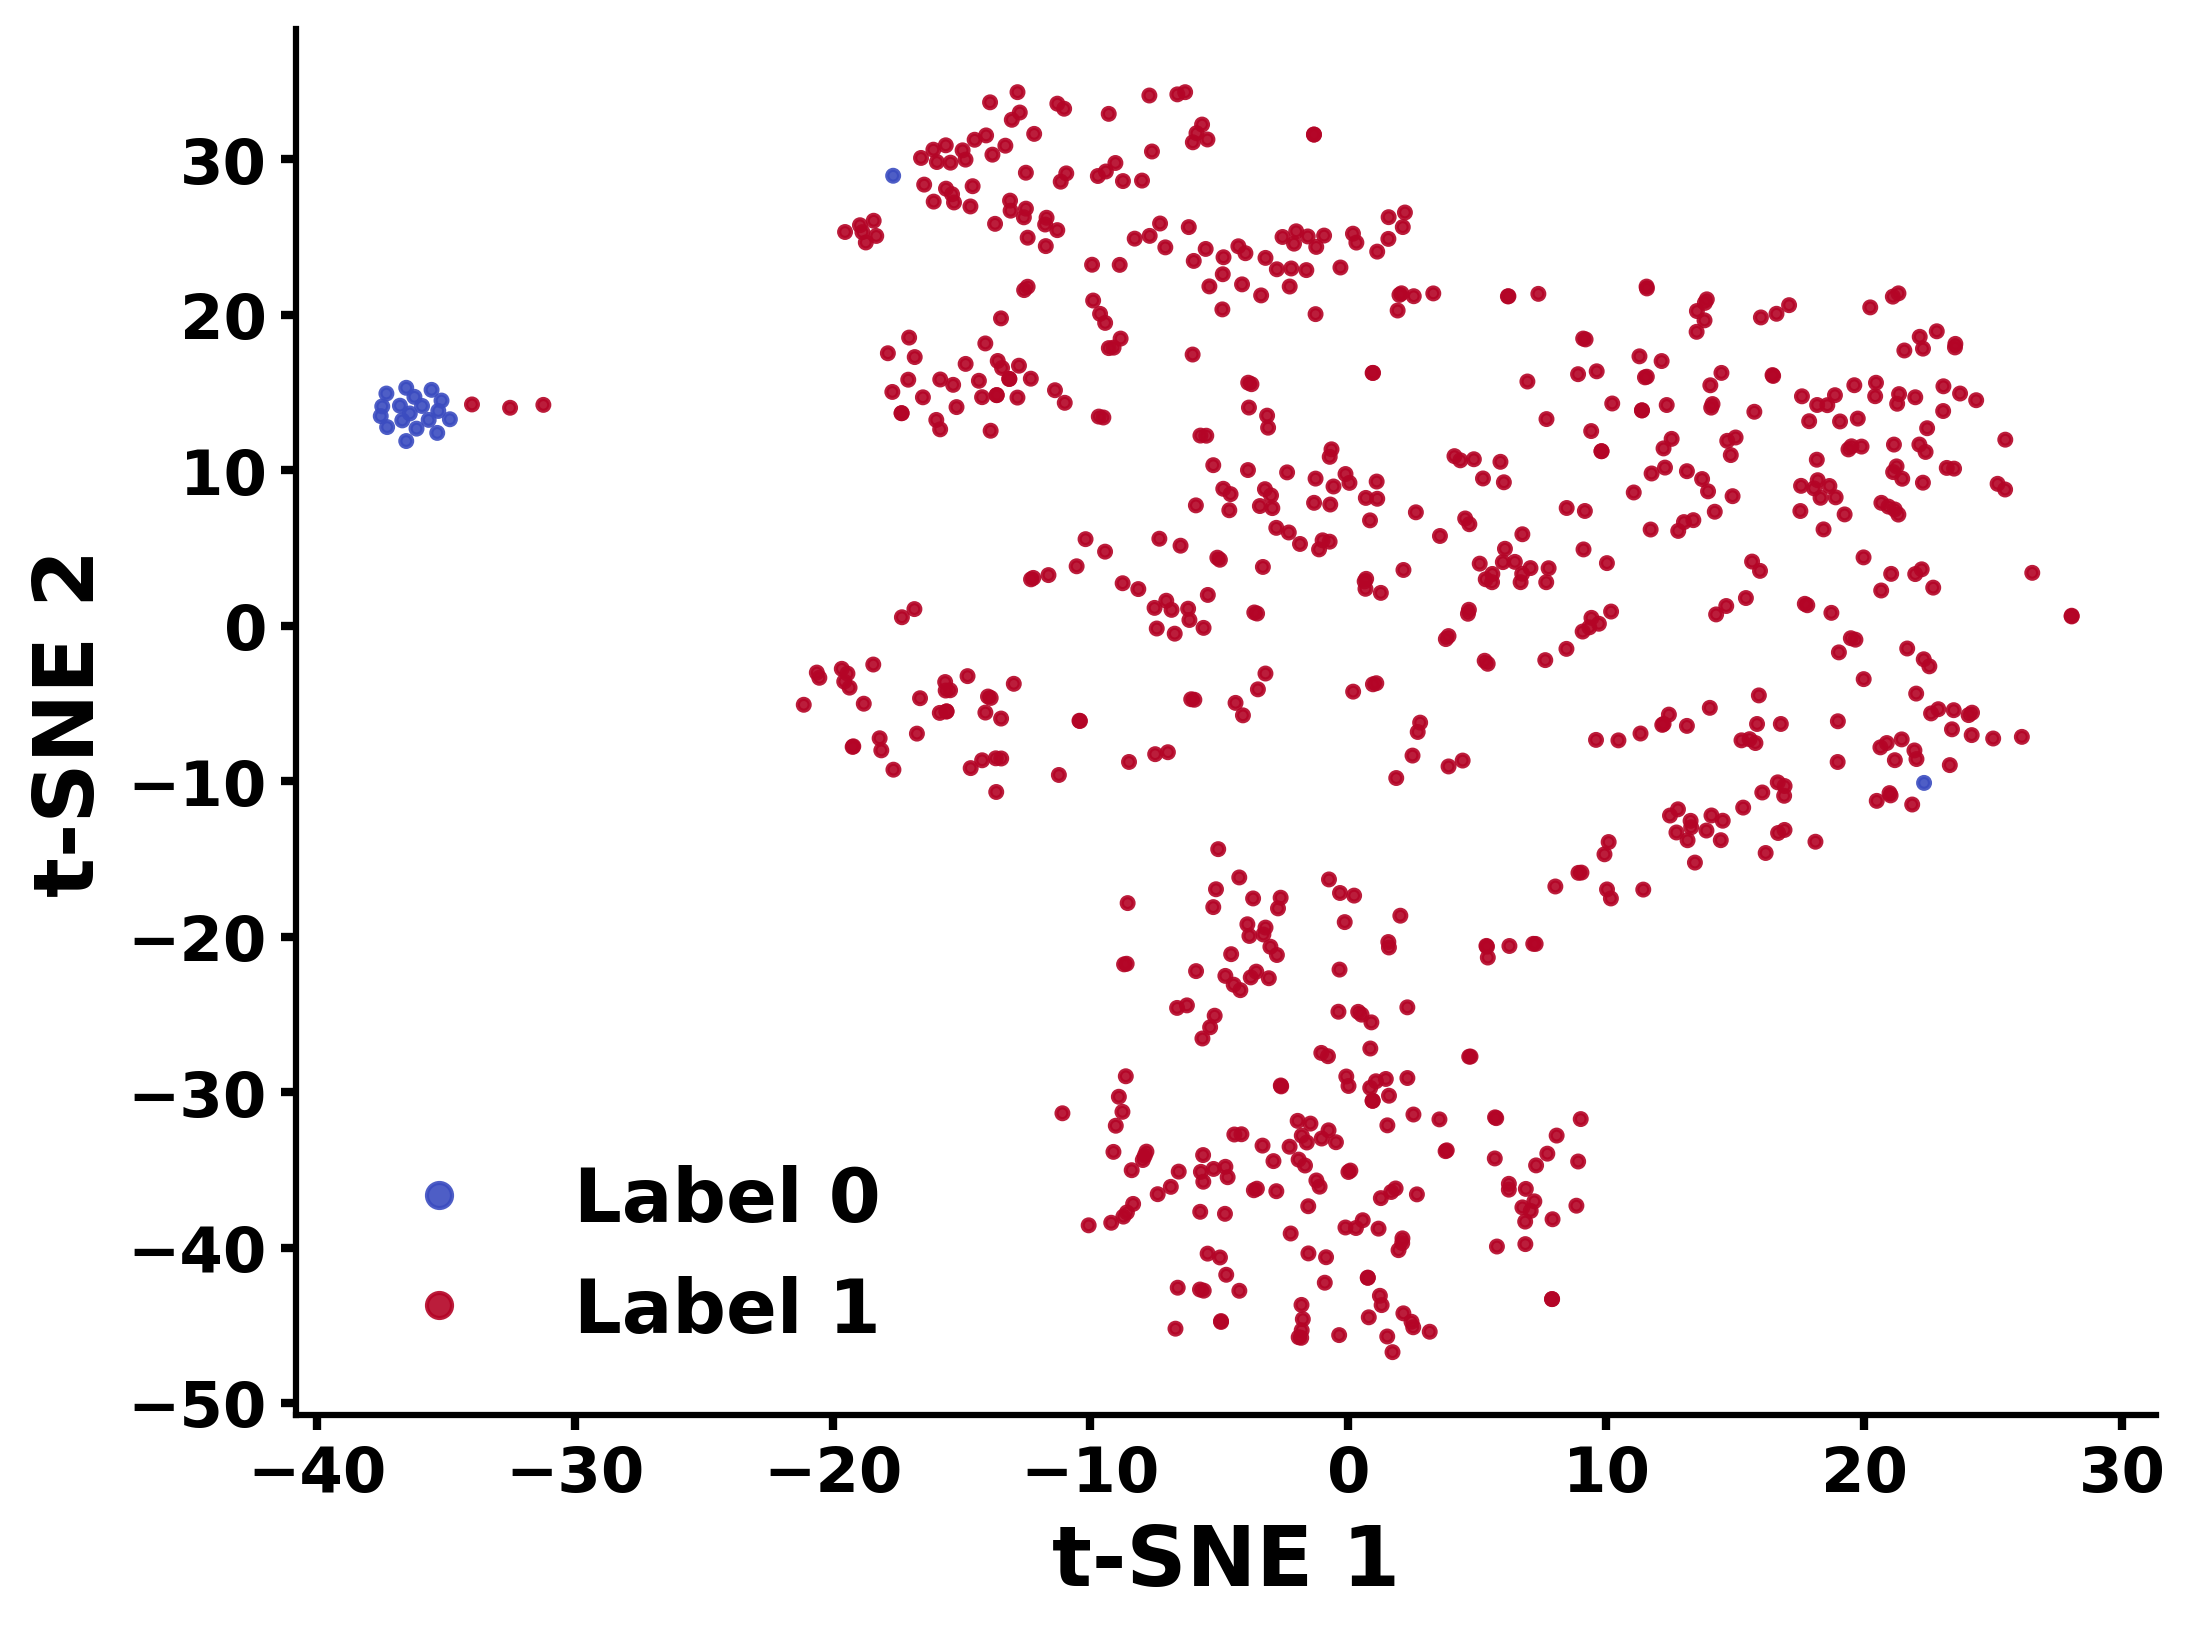

In [13]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from matplotlib import font_manager



# 使用 t-SNE 对嵌入进行降维，同时获取每个主成分的解释方差百分比
def apply_tsne(embeddings, n_components=2):
    tsne = TSNE(n_components=n_components, random_state=42)
    tsne_result = tsne.fit_transform(embeddings)
    return tsne_result

def plot_tsne_with_variance(tsne_result, labels):
    plt.figure(figsize=(8, 6), dpi=300)
    
    # 绘制散点图，使用 'coolwarm' colormap，labels 作为着色依据
    scatter = plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=labels, cmap='coolwarm', alpha=0.9, s=8)

    # 添加图例，并加粗字体
    legend = plt.legend(
        handles=scatter.legend_elements()[0], 
        labels=['Label 0', 'Label 1'], 
        loc='best', 
        fontsize=18,
        frameon=False
    )
    for text in legend.get_texts():
        text.set_fontweight('bold')  # 加粗图例文本

    # 设置坐标轴标签，并加粗
    plt.xlabel('t-SNE 1', fontsize=20, fontweight='bold')
    plt.ylabel('t-SNE 2', fontsize=20, fontweight='bold')

    # 获取当前坐标轴对象
    ax = plt.gca()

    # 设置边框的可见性、颜色和加粗
    ax.spines['top'].set_visible(False)    
    ax.spines['right'].set_visible(False)  
    ax.spines['bottom'].set_visible(True)  
    ax.spines['left'].set_visible(True)  

    ax.spines['top'].set_color('black')   
    ax.spines['right'].set_color('black') 
    ax.spines['bottom'].set_color('black')  
    ax.spines['left'].set_color('black')  

    ax.spines['top'].set_linewidth(1.5)   
    ax.spines['right'].set_linewidth(1.5) 
    ax.spines['bottom'].set_linewidth(1.5)  
    ax.spines['left'].set_linewidth(1.5)  

    # 加粗 x 轴和 y 轴刻度
    ax.tick_params(axis='both', labelsize=15, width=2)
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontweight('bold')  # 加粗刻度标签

    # 显示图形
    plt.show()



# 使用 t-SNE 降维
tsne_result = apply_tsne(smiles_embeddings, n_components=2)

# 绘制 t-SNE 图
plot_tsne_with_variance(tsne_result, labels)


In [11]:
import xgboost as xgb

In [12]:
X=smiles_embeddings
y=labels

In [13]:
import joblib

In [ ]:
{'n_estimators': 177, 'max_depth': 40, 'learning_rate': 0.9188658231107774,'eval_metric': 'error' }

In [14]:

# 2. 设置最佳超参数
best_params_xgb = {
    'n_estimators': 177,
    'max_depth': 40,
    'learning_rate': 0.9188658231107774,
    'eval_metric': 'error',  # 使用分类错误率作为评估指标
    'objective': 'binary:logistic'  # 二分类问题
}

# 3. 创建 XGBoost 模型
xgb_model = xgb.XGBClassifier(**best_params_xgb)
xgb_model.fit(X, y)


model_save_path="./final_xgb.joblib"
joblib.dump(xgb_model, model_save_path)  # 保存模型
xgb_booster = joblib.load("final_xgb.joblib")

# 转换为 XGBoost 的 JSON 格式
xgb_booster.save_model("final_xgb.json")

In [ ]:
#预测危险化合物

In [15]:
HazardChem = pd.read_csv("./Hazard-chemical-list.csv")

In [ ]:
HC_y_pred =HazardChem['SMILES'].tolist()

In [16]:
HC_SMILES =  HazardChem['SMILES'].tolist()

In [16]:
HC_smiles_embeddings = extract_embeddings(HC_SMILES, model, tokenizer, device)

In [18]:
HC_y_pred = xgb_model.predict(HC_smiles_embeddings)

In [15]:

HazardChem = pd.read_csv("./hzc_flammability.csv")
HC_SMILES =  HazardChem['SMILES'].tolist()
HC_y_pred =HazardChem['labels'].tolist()

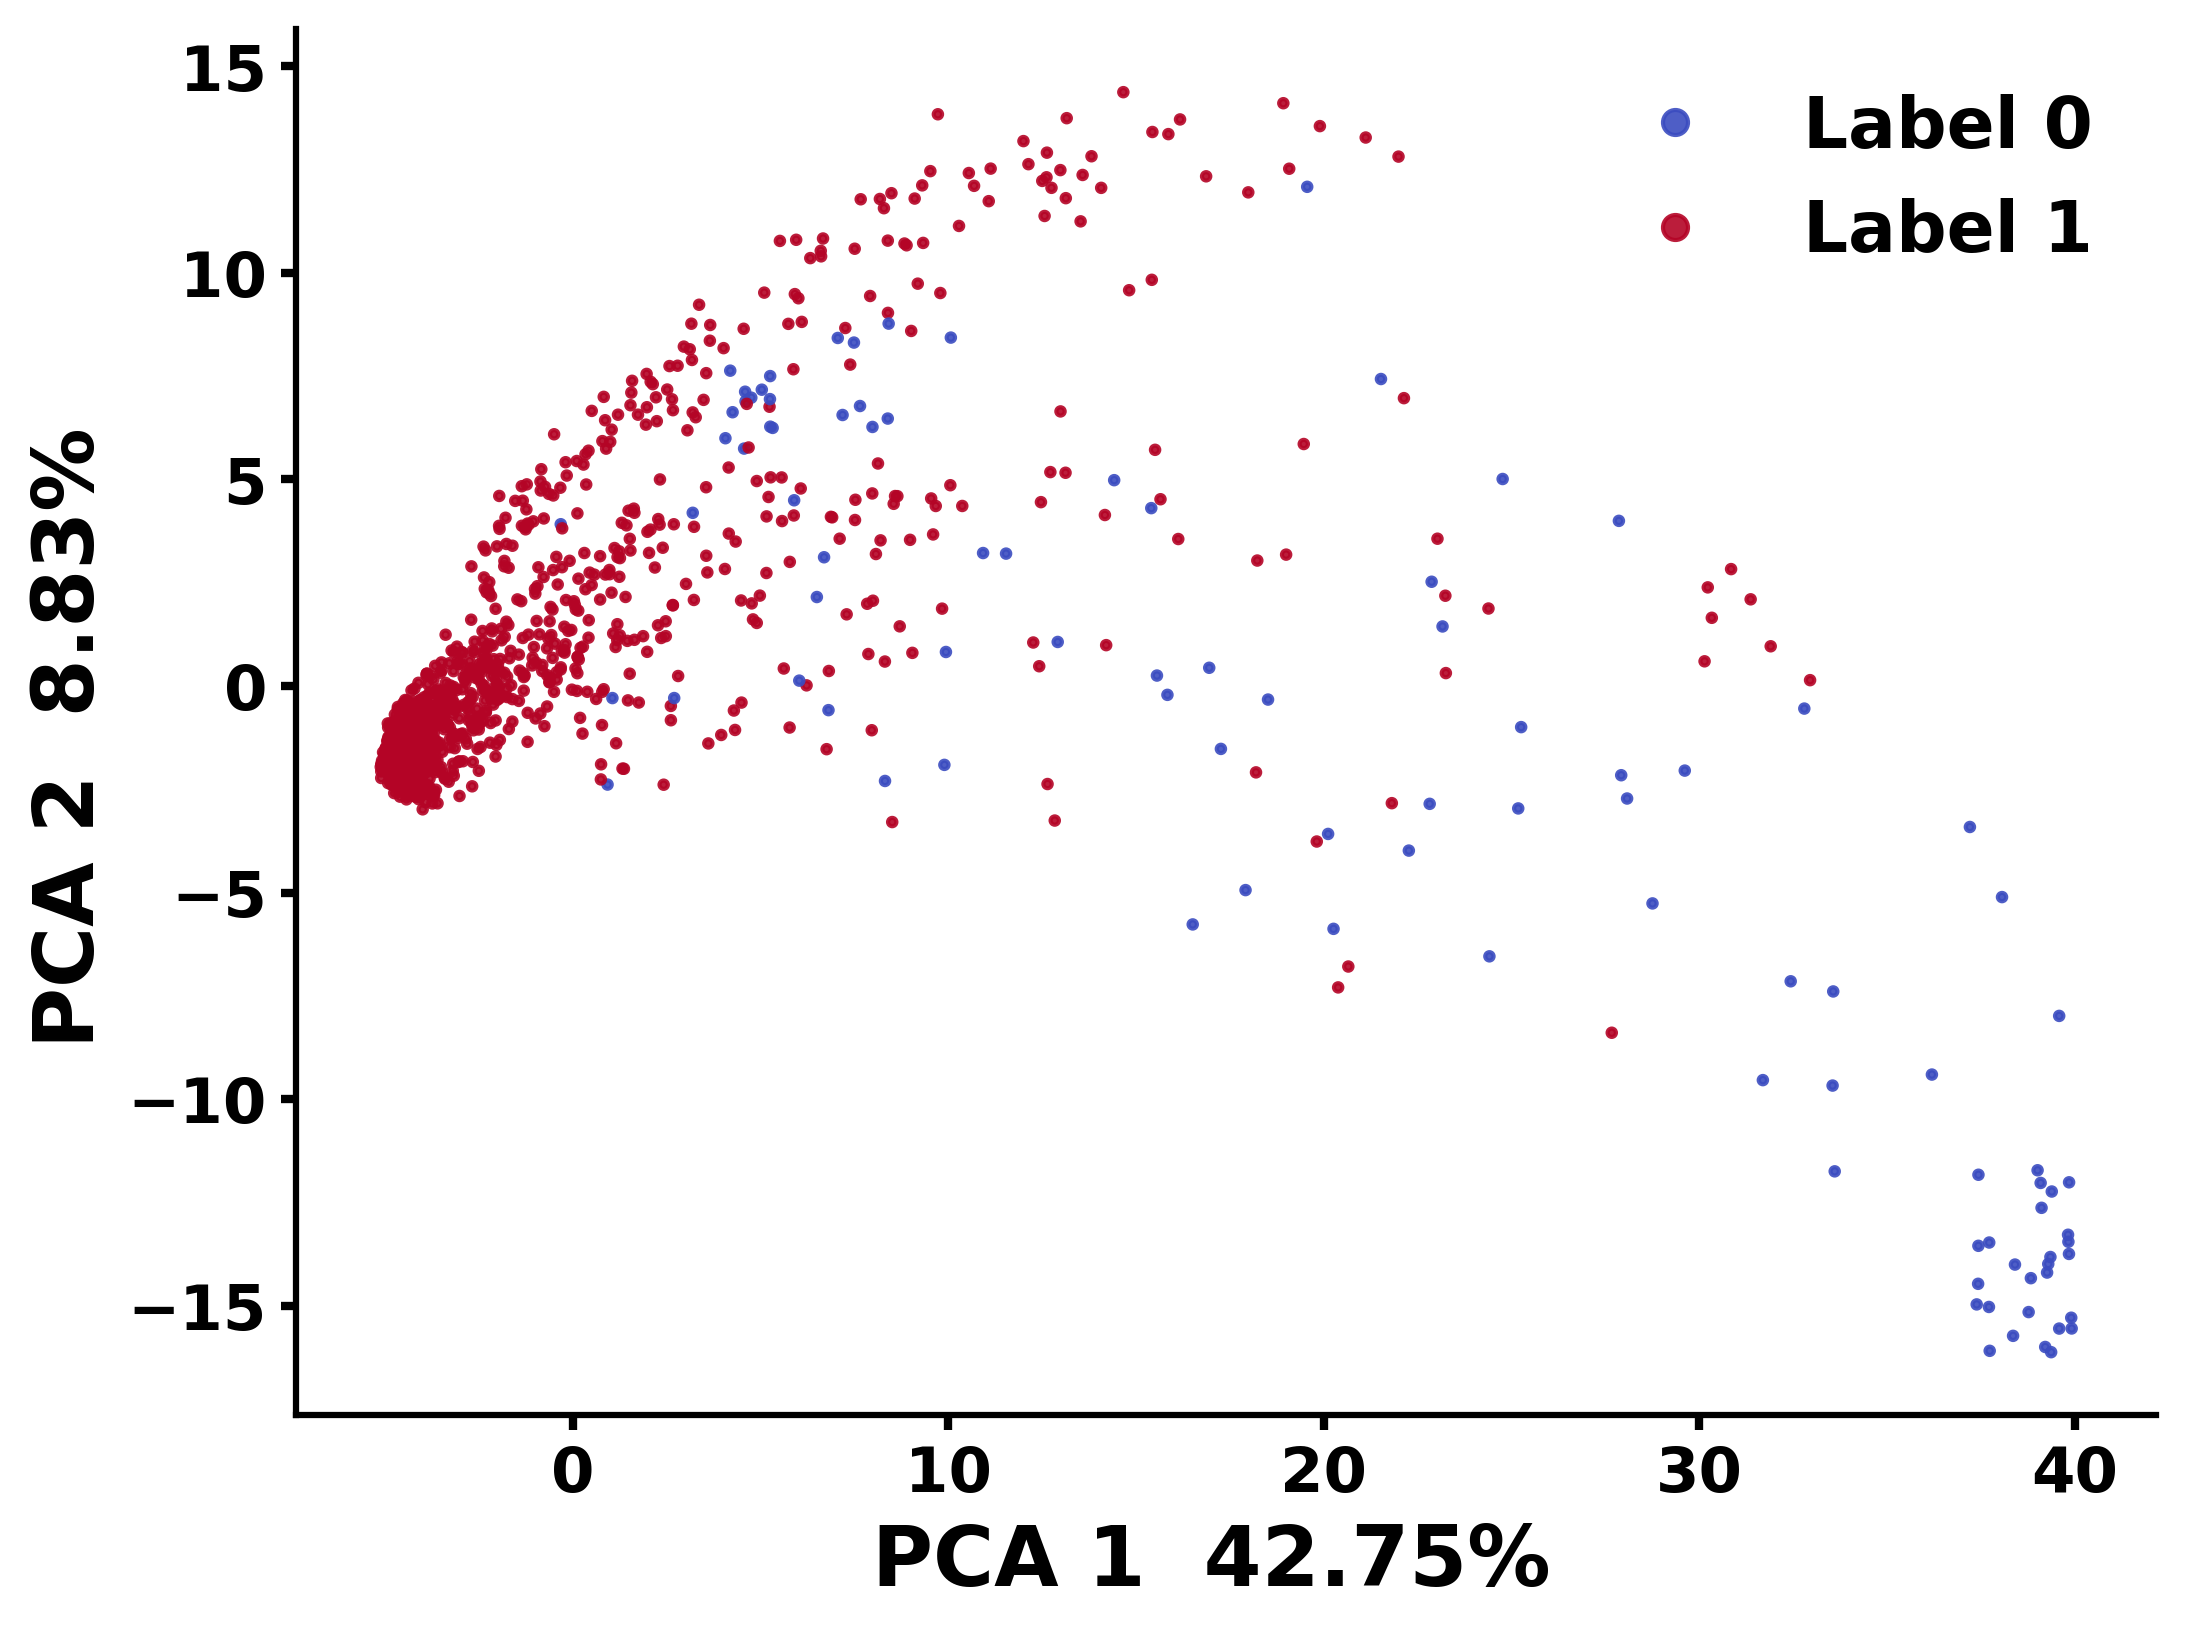

In [17]:



# 使用 PCA 降维，并获取解释方差
pca_result, explained_variance = apply_pca(HC_smiles_embeddings, n_components=2)

# 绘制 PCA 图，并显示每个主成分的解释方差百分比
plot_pca_with_variance(pca_result, HC_y_pred, explained_variance)

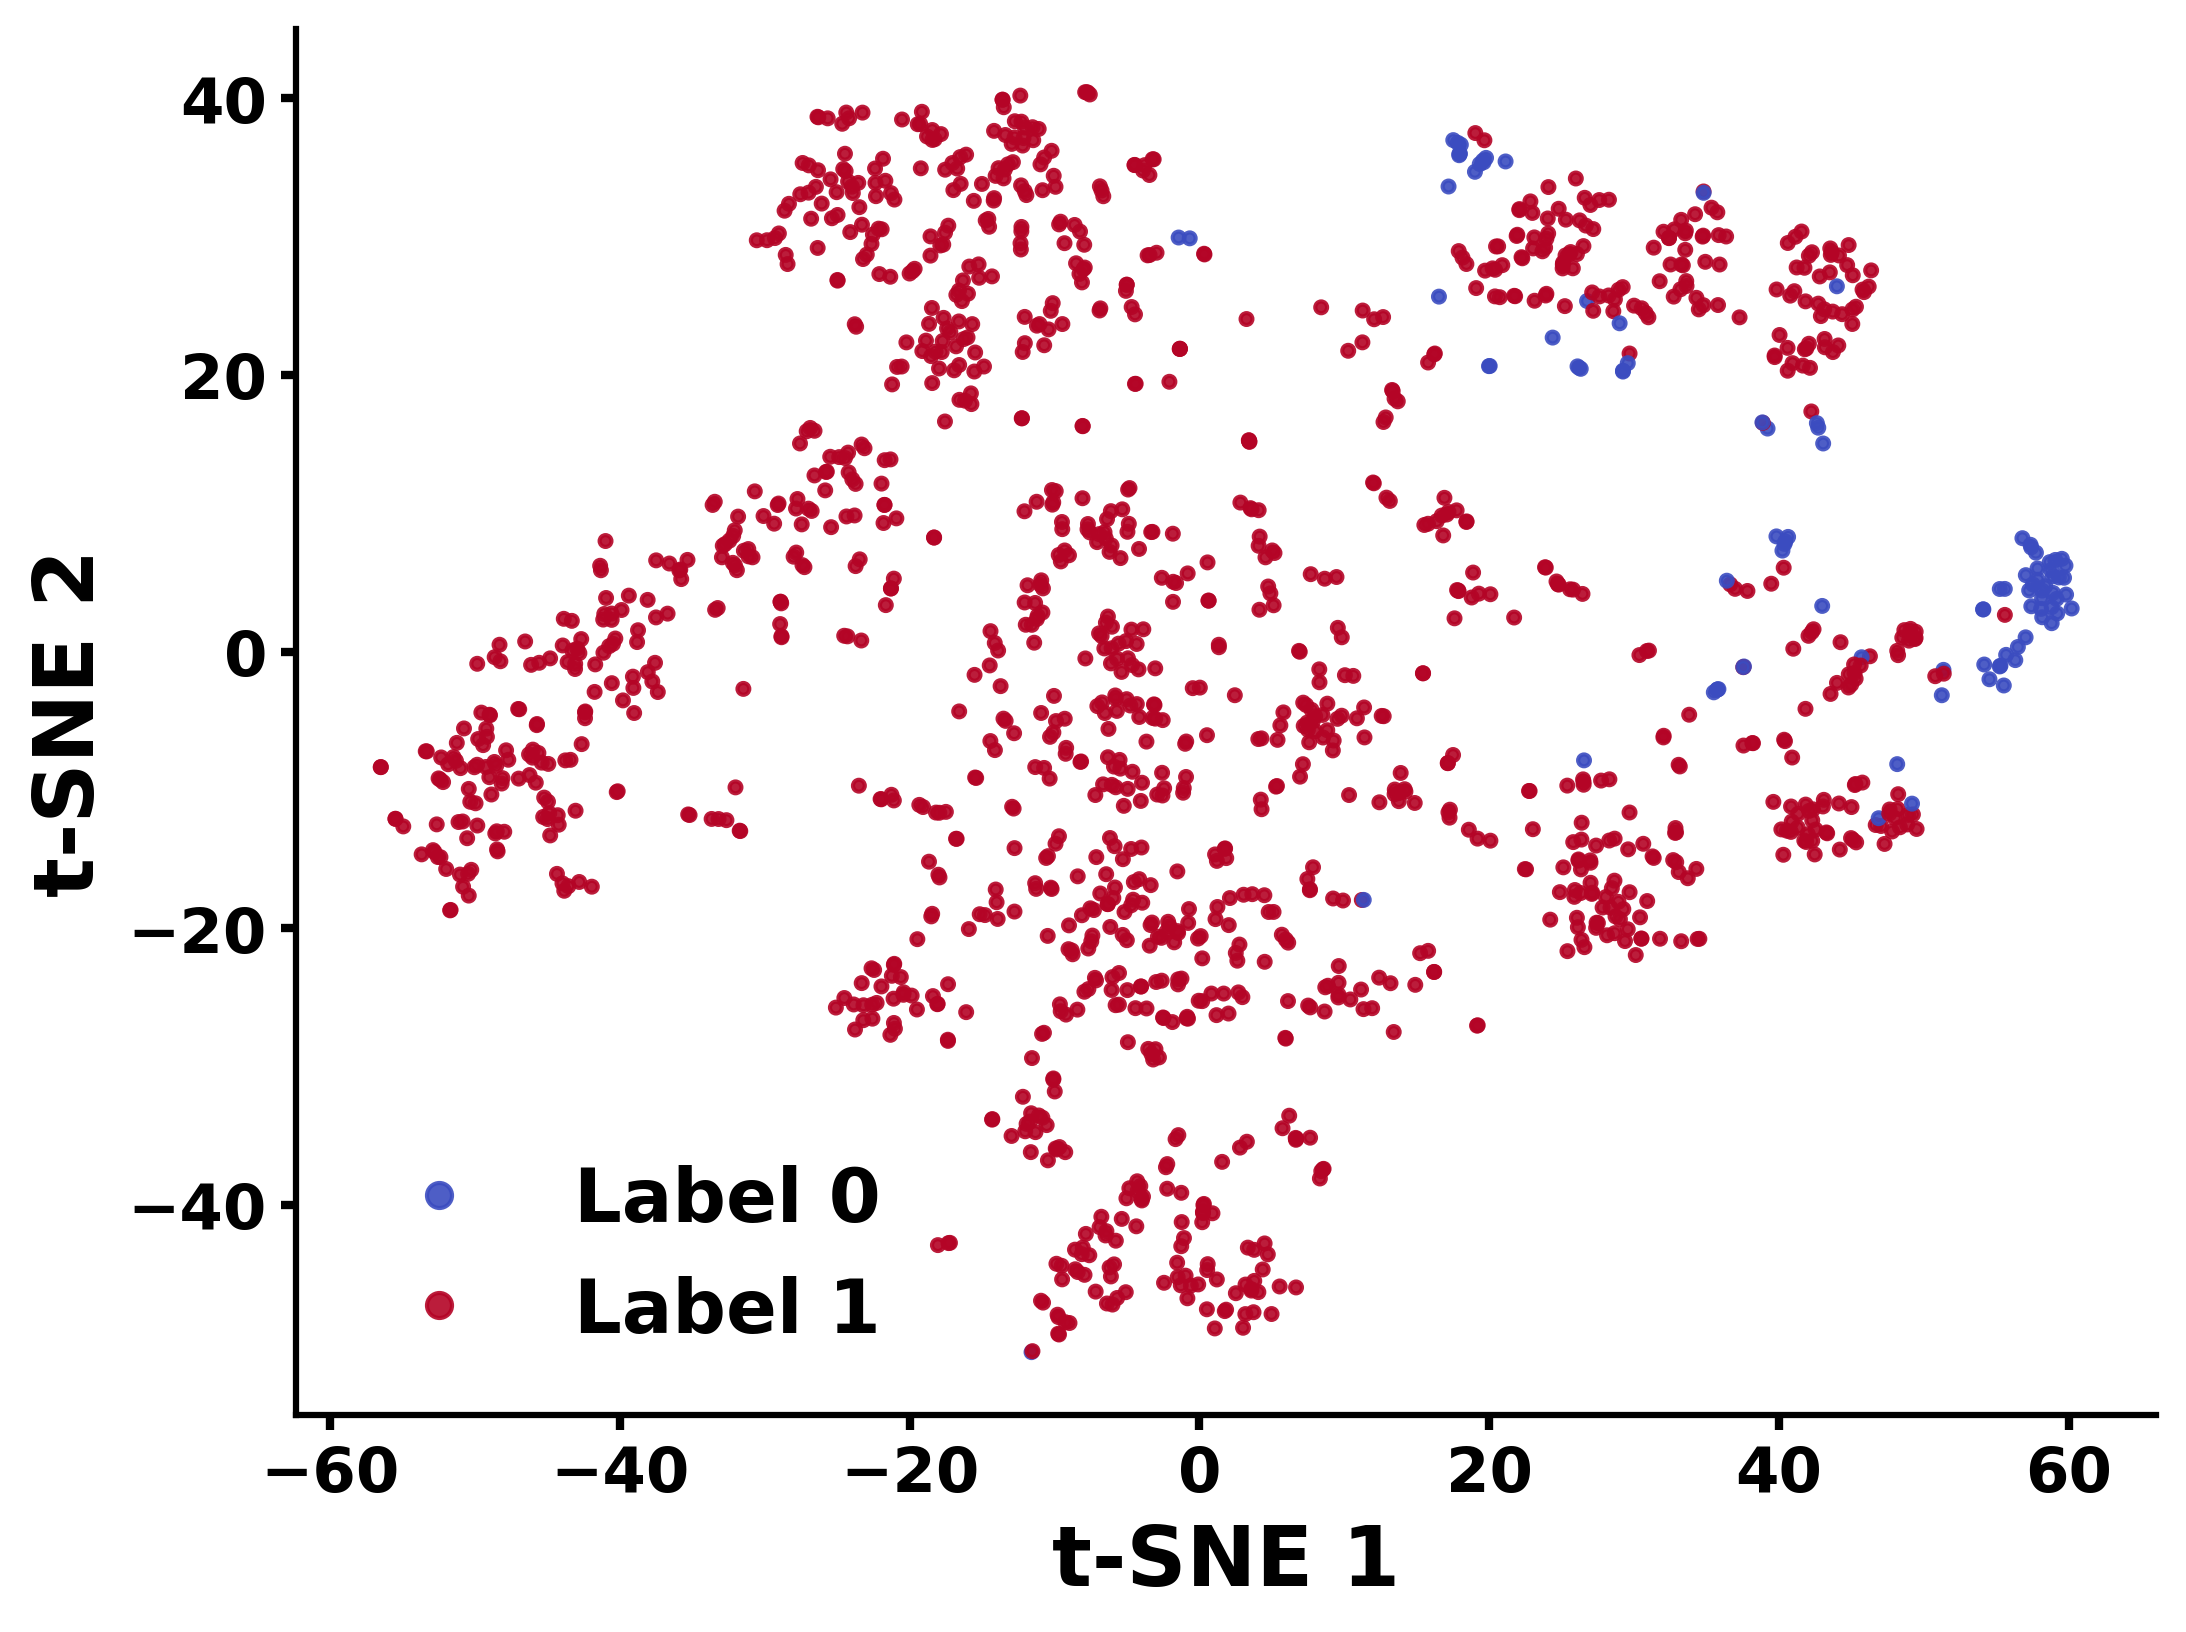

In [18]:


# 使用 t-SNE 降维
tsne_result = apply_tsne(HC_smiles_embeddings, n_components=2)

# 绘制 t-SNE 图
plot_tsne_with_variance(tsne_result, HC_y_pred)

In [21]:
HC_y_pred

array([1, 1, 1, ..., 1, 1, 1], shape=(1499,))

In [22]:
import numpy as np


# 统计0和1的数量
unique, counts = np.unique(HC_y_pred, return_counts=True)
count_dict = dict(zip(unique, counts))

count_dict

{np.int64(0): np.int64(99), np.int64(1): np.int64(1400)}

In [23]:
HazardChem['labels'] = HC_y_pred

In [24]:
HazardChem.to_csv('./hzc.csv')